In [196]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
data = pd.read_csv("census_income.csv")
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x) #去除左右空格

# 检查数据集是否存在缺失值和异常值，如果存在，则消除它们

In [197]:
# 缺失值检测
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    3
native-country    0
income            0
dtype: int64

In [198]:
# 缺失值处理
# 仅有三行有缺失值，直接删除有缺失值的行
data = data.loc[data.isnull().sum(axis=1) == 0]

age                 int64
workclass          object
fnlwgt              int64
education          object
education-num       int64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain        int64
capital-loss        int64
hours-per-week    float64
native-country     object
income             object
dtype: object
6


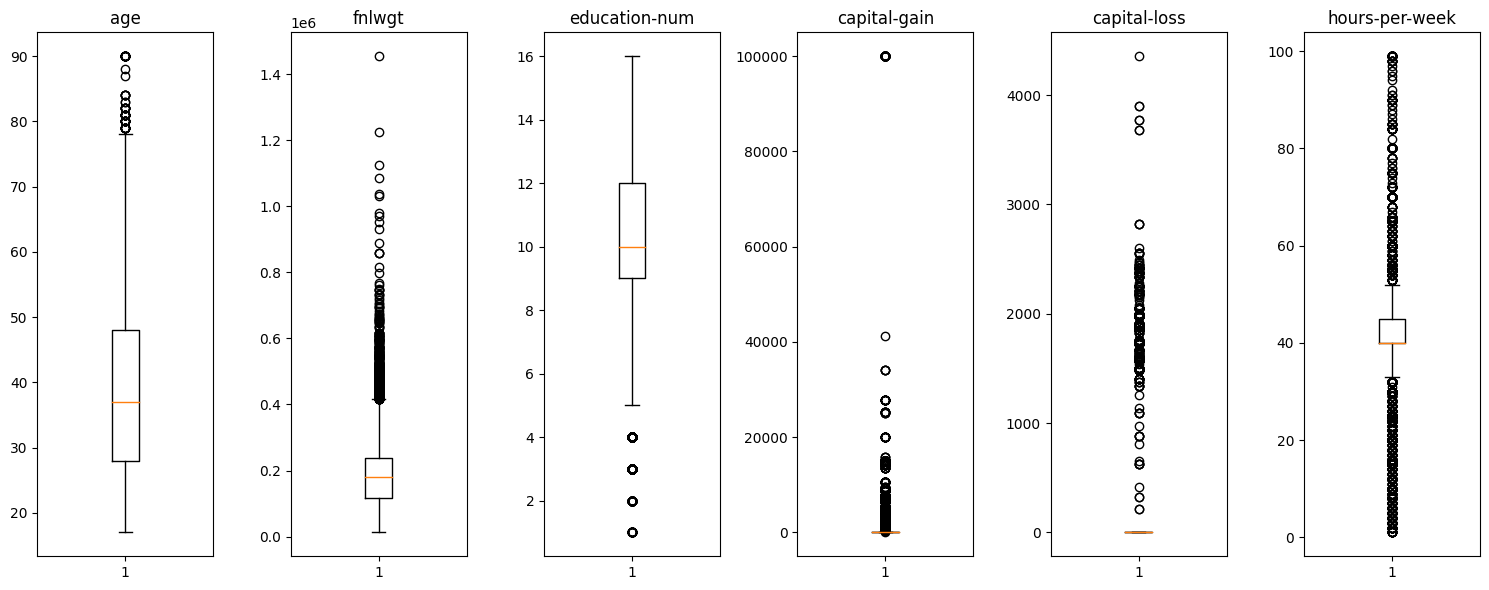

In [201]:
numeric_columns = data.select_dtypes(include=['float', 'int'])
plt.figure(figsize=(15, 6))

print(data.dtypes)

num_numeric_features = len(data.select_dtypes(exclude=['object']).columns)
print(num_numeric_features)

index = 1

for i, column in enumerate(data.columns):
	if data[column].dtypes != object:
		plt.subplot(1, num_numeric_features, index)
		plt.boxplot(data[column])
		plt.title(column)
		index += 1

plt.subplots_adjust(wspace=0.5)  # Adjust the horizontal spacing between subplots
plt.tight_layout()
plt.show()


In [ ]:
# 在该数据集下箱型图不容易看出异常值，所以我们改用孤立森林算法
model = IsolationForest(contamination=0.01)  # 可调节contamination参数来控制异常值的比例
model.fit(data[numeric_columns.columns])
data['anomaly'] = model.predict(data[numeric_columns.columns]) # anomaly为-1意味着为异常值
cnt = len(data[data['anomaly'] == -1])
print(f'丢弃异常值前有{len(data)}行')
print(f'异常值有{cnt}行')
data = data[data['anomaly'] != -1] #丢掉被标记为异常值的行
data = data.drop('anomaly',axis=1)
print(f'丢弃异常值后有{len(data)}行')

丢弃异常值前有16278行
异常值有163行
丢弃异常值后有16115行


# 预测标签的处理

In [ ]:
# 将 "income" 列转换为目标类别标签
data['income'] = data['income'].map({'<=50K': 0, '>50K': 1})

# 字符型特征处理

In [ ]:
# 对education按教育程度高低进行数值编码
education_mapping = {
    'Preschool': 0,
    '1st-4th': 1,
    '5th-6th': 2,
    '7th-8th': 3,
    '9th': 4,
    '10th': 5,
    '11th': 6,
    '12th': 7,
    'HS-grad': 8,
    'Some-college': 9,
    'Assoc-voc': 10,
    'Assoc-acdm': 11,
    'Bachelors': 12,
    'Masters': 13,
    'Prof-school': 14,
    'Doctorate': 15
}
# 对DataFrame中的教育程度列进行编码
data['education'] = data['education'].map(education_mapping)

In [ ]:
# 其他特征用sklearn包进行编码
labelEncoder = LabelEncoder()
for col in data.columns:
	if data[col].dtype == 'object':
		data[col] = labelEncoder.fit_transform(data[col])

# 构造特征

In [ ]:
# 资本净收入 = 资本收入 - 资本支出
data['capital-netGain'] = data['capital-gain'] - data['capital-loss']

# 归一化处理

In [ ]:
# 创建 MinMaxScaler 对象
minmax_scaler = MinMaxScaler()
# 对数值属性进行归一化
df_normalized = minmax_scaler.fit_transform(data)
# 将归一化后的数据转换为DataFrame
# data = pd.DataFrame(df_normalized, columns=data.columns)

# 删除education-num

In [ ]:
# data.drop("education-num",axis=1,inplace=True)
# data.drop("fnlwgt",axis=1,inplace=True)

# 添加是否有gain与loss

In [ ]:
data['is-gain'] = data['capital-gain'].apply(lambda x: 1 if x > 0 else 0)
data['is-loss'] = data['capital-loss'].apply(lambda x: 1 if x > 0 else 0)

# 划分测试训练数据集，对训练集进行SMOTE处理不平衡标签

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
# 将数据集划分为X和y
X = data.drop('income',axis=1)
y = data['income']
# 将数据集划分为训练集和测试集，其中测试集占总数据集的20%
X_train, X_test, y_train, y_test = train_test_split(X, y,
													test_size=.3,
													random_state=42)


print(y_train.value_counts())
ros = RandomOverSampler(random_state=42)
# X_train, y_train = ros.fit_resample(X_train, y_train)

# sm = SMOTE(random_state=42)
# X_train, y_train = sm.fit_resample(X_train, y_train)

y_train.value_counts()

income
0    8641
1    2639
Name: count, dtype: int64


income
0    8641
1    2639
Name: count, dtype: int64

# 输出处理完成后的数据

In [ ]:
X_train.to_csv('X_train.csv',index=False)
X_test.to_csv('X_test.csv',index=False)
y_train.to_csv('y_train.csv',index=False)
y_test.to_csv('y_test.csv',index=False)